(92151, 1, 40, 40)
(92151, 1, 40, 40)
------- 359 0 14232.507529043554 2019-07-31 17:52:15
------- 359 1 1168.0790416111854 2019-07-31 17:52:37
------- 359 2 734.5102025672254 2019-07-31 17:52:58
------- 359 3 1354.278639025675 2019-07-31 17:53:20
------- 359 4 2540.2967646314573 2019-07-31 17:53:42
------- 359 5 1769.2389191518587 2019-07-31 17:54:04
------- 359 6 269.4054135877774 2019-07-31 17:54:25
------- 359 7 296.1751258340055 2019-07-31 17:54:47
------- 359 8 578.0547196426763 2019-07-31 17:55:09
------- 359 9 972.8699024381079 2019-07-31 17:55:32


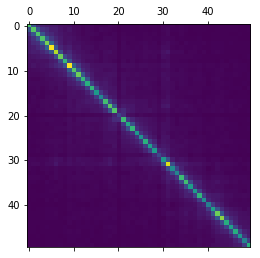

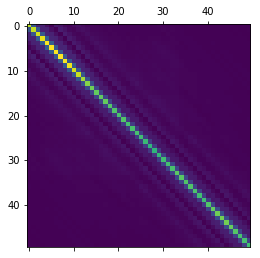

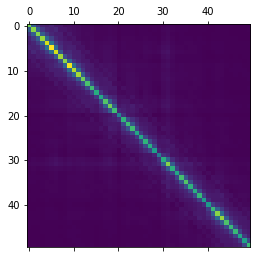

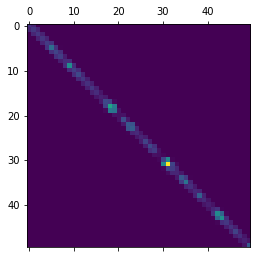

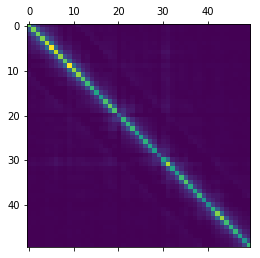

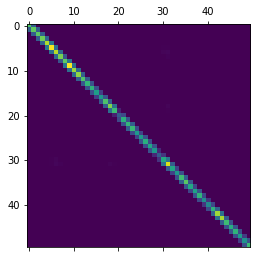

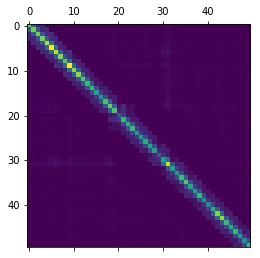

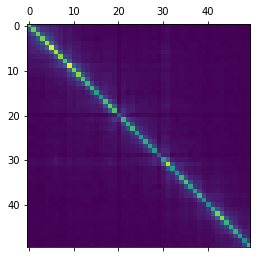

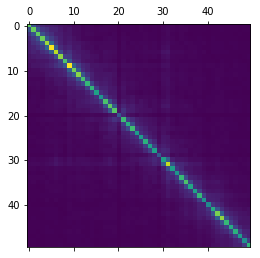

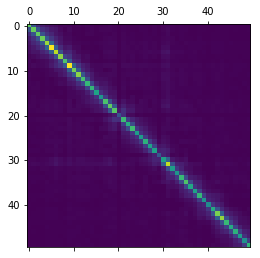

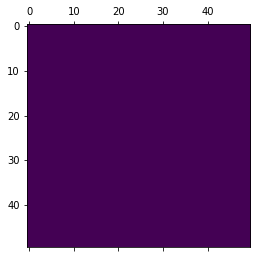

In [20]:
# input of this script is npy files including frames which are samples


import os
import sys
dir_path = "/Users/neda/HiCPlus_pytorch/src"

model_path = dir_path + "/models"
sys.path.insert(0, model_path)
utils_path = dir_path + "/utils"
sys.path.insert(0, utils_path)
import model
import model2
import utils
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
from torch.utils import data
import torch
import torch.optim as optim
from torch.autograd import Variable
from time import gmtime, strftime
import torch.nn as nn
import argparse

"""
ap = argparse.ArgumentParser()
ap.add_argument("--LowRes_frames_path", help = "path of npy file including LowRes frames", required = True)
ap.add_argument("--HighRes_frames_path", help = "path of npy file including HighRes frames", required = True)
ap.add_argument("--batch_size", help = "batch size in learning process", required = True, type = int)
ap.add_argument("--epochs", help = "number of epochs", required = True, type = int)
ap.add_argument("--output_network_path", help = "path of folder to save learned network", required = True)
ap.add_argument("--network_name", help = "name of network for saving", required = True)
args = vars(ap.parse_args())
"""

args = {
    "LowRes_frames_path" : "/Users/neda/HiCPlus_pytorch/data/divided-data/GM12878-chr1-17.npy"
    , "HighRes_frames_path" : "/Users/neda/HiCPlus_pytorch/data/divided-data/GM12878-chr1-17.npy"
    , "batch_size" : 256
    , "epochs" : 10
    #, "output_network_path" :
    #, "network_name" : 
}

use_gpu = 0
# down_sample_ratio = 16 learn with scaling or not????
epochs = args['epochs']
#HiC_max_value = 100 # ?????
batch_size = args['batch_size']

low_resolution_samples = np.load(args['LowRes_frames_path']).astype(np.float32)
low_resolution_samples = low_resolution_samples/5
low_resolution_samples = np.expand_dims(low_resolution_samples, axis=1)
high_resolution_samples = np.load(args['HighRes_frames_path']).astype(np.float32)
high_resolution_samples = np.expand_dims(high_resolution_samples, axis=1)
#high_resolution_samples = np.minimum(high_resolution_samples, HiC_max_value)
#low_resolution_samples = np.minimum(low_resolution_samples, HiC_max_value)
print(low_resolution_samples.shape)
print(high_resolution_samples.shape)
sample_size = low_resolution_samples.shape[-1]
half_padding = model.half_padding
lb = int(half_padding)
ub = int(sample_size - half_padding)
high_resolution_samples = high_resolution_samples[:,:,lb:ub,lb:ub]
lowres_loader = torch.utils.data.DataLoader(torch.from_numpy(low_resolution_samples), batch_size=batch_size, shuffle=False)
hires_loader = torch.utils.data.DataLoader(torch.from_numpy(high_resolution_samples), batch_size=batch_size, shuffle=False)

enhanced_chr18_mat = np.load("/Users/neda/HiCPlus_pytorch/data/GM12878_primary_10kb/chr18.txt_npy_form_tmp.npy")/5
chr18_frames, chr18_indices = utils.divide2(enhanced_chr18_mat,18)
chr18_frames = np.stack(chr18_frames, axis = 0)
chr18_frames = np.expand_dims(chr18_frames, axis = 1)
chr18_indices = np.stack(chr18_indices, axis = 0)
l = 2200
u = 2250
plt.matshow(enhanced_chr18_mat[l:u,l:u])

Net = model.Net(40, 28)
if use_gpu:
    Net = Net.cuda()
optimizer = optim.SGD(Net.parameters(), lr = 0.00001)
_loss = nn.MSELoss()
Net.train()
running_loss = 0.0
losslist = []
for epoch in range(0, epochs):
    # iterate over two lists and their indices using enumerate together with zip
    # lowres_loader is list of batches
    for i, (v1, v2) in enumerate(zip(lowres_loader, hires_loader)):
        # probably it is for skipping last incomplete batch
        if (i == len(lowres_loader) - 1):
            continue
        _lowRes = Variable(v1)
        _highRes = Variable(v2)
        if use_gpu:
            _lowRes = _lowRes.cuda()
            _highRes = _highRes.cuda()
        optimizer.zero_grad()
        y_prediction = Net(_lowRes)
        loss = _loss(y_prediction, _highRes)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print ('-------', i, epoch, running_loss/i, strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    losslist.append(running_loss/i)
    running_loss = 0.0
    chr18_prediction = Net(Variable(torch.from_numpy(chr18_frames).float()))
    chr18_prediction = chr18_prediction.data.cpu().numpy()
    chr18_prediction = np.reshape(chr18_prediction, (chr18_prediction.shape[0], chr18_prediction.shape[2], chr18_prediction.shape[3]))
    enhanced_chr18_mat = np.load("/Users/neda/HiCPlus_pytorch/data/GM12878_primary_10kb/chr18.txt_npy_form_tmp.npy")/5
    for i in range(chr18_indices.shape[0]):
        x_pos = chr18_indices[i,1]
        y_pos = chr18_indices[i,2]
        enhanced_chr18_mat[x_pos+6:x_pos+34,y_pos+6:y_pos+34] = chr18_prediction[i,:,:]

    iu = np.triu_indices(enhanced_chr18_mat.shape[0],1)
    il = (iu[1],iu[0])
    enhanced_chr18_mat[il]=enhanced_chr18_mat[iu]
    plt.matshow(enhanced_chr18_mat[l:u,l:u])


In [21]:
enhanced_chr18_mat[2000:2010,2000:2010]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
high_chr18_mat = np.load("/Users/neda/HiCPlus_pytorch/data/GM12878_primary_10kb/chr18.txt_npy_form_tmp.npy")

In [19]:
high_chr18_mat[2000:2010,2000:2010]

array([[1069,  348,  169,  104,   74,   91,   49,   32,   54,   71],
       [ 348, 1243,  444,  176,   84,  115,   65,   44,   65,   79],
       [ 169,  444, 1071,  388,  137,  164,   71,   62,   67,   84],
       [ 104,  176,  388, 1207,  265,  228,  114,   58,   68,   83],
       [  74,   84,  137,  265,  932,  302,  131,   70,   62,   67],
       [  91,  115,  164,  228,  302, 1753,  414,  171,  156,  153],
       [  49,   65,   71,  114,  131,  414,  972,  222,  152,  119],
       [  32,   44,   62,   58,   70,  171,  222,  588,  201,  141],
       [  54,   65,   67,   68,   62,  156,  152,  201, 1103,  403],
       [  71,   79,   84,   83,   67,  153,  119,  141,  403, 1583]],
      dtype=int16)